In [ ]:
pip install pandas matplotlib seaborn

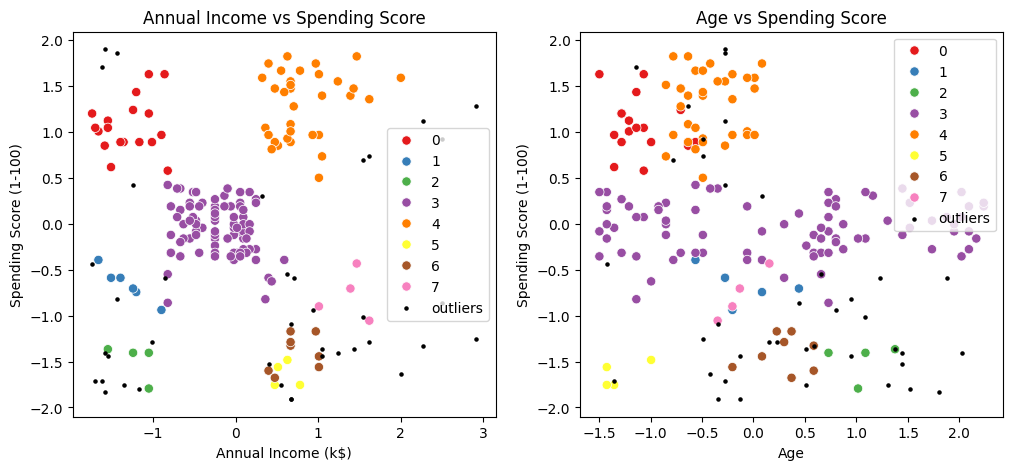

,count
Cluster,
3,83
-1,39
4,34
0,18
6,8
1,6
2,4
5,4
7,4


In [1]:
from typing import List, Dict
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

class Point:
    def __init__(self, coords: List[float]):
        self.coords = coords
        self.cluster_id = -1
        self.visited = False

class DBSCAN:
    def __init__(self, epsilon: float, min_pts: int):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.points = []
        self.clusters = {}

    def add_point(self, point: List[float]):
        self.points.append(Point(point))

    def fit(self):
        cluster_id = 0
        for point in self.points:
            if not point.visited:
                point.visited = True
                neighbors = self.region_query(point)
                if len(neighbors) < self.min_pts:
                    point.cluster_id = -1  # Mark as noise
                else:
                    self.expand_cluster(point, neighbors, cluster_id)
                    cluster_id += 1

    def region_query(self, point: Point) -> List[Point]:
        neighbors = []
        for p in self.points:
            if self.distance(point.coords, p.coords) <= self.epsilon:
                neighbors.append(p)
        return neighbors

    def expand_cluster(self, point: Point, neighbors: List[Point], cluster_id: int):
        point.cluster_id = cluster_id
        cluster = [point.coords]
        stack = deque(neighbors)

        while stack:
            neighbor = stack.pop()
            if not neighbor.visited:
                neighbor.visited = True
                new_neighbors = self.region_query(neighbor)
                if len(new_neighbors) >= self.min_pts:
                    stack.extend(new_neighbors)
            if neighbor.cluster_id == -1:
                neighbor.cluster_id = cluster_id
                cluster.append(neighbor.coords)

        self.clusters[cluster_id] = cluster

    def get_clusters(self) -> Dict[int, List[List[float]]]:
        clusters_with_noise = self.clusters.copy()
        noise = [p.coords for p in self.points if p.cluster_id == -1]
        clusters_with_noise[-1] = noise
        return clusters_with_noise

    @staticmethod
    def distance(point1: List[float], point2: List[float]) -> float:
        return sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5

# Load the dataset
file_path = 'Mall_Customers.csv'
data = pd.read_csv(file_path)

# Drop missing values
data.dropna(inplace=True)

# Select relevant columns for clustering
X_numerics = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerics)

# Parameters
eps = 0.5
min_samples = 4

# Initialize DBSCAN
dbscan = DBSCAN(epsilon=eps, min_pts=min_samples)

# Add points to the DBSCAN instance
for point in X_scaled:
    dbscan.add_point(point.tolist())

# Fit the model
dbscan.fit()

# Get the clusters
clusters = dbscan.get_clusters()

# Convert clusters to a DataFrame for analysis
clustered_data = []
for cluster_id, points in clusters.items():
    for point in points:
        clustered_data.append(point + [cluster_id])

df_clusters = pd.DataFrame(clustered_data, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster'])

# Plotting the clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='Cluster', palette='Set1', data=df_clusters[df_clusters['Cluster']!=-1], ax=ax1, legend='full', s=45
)

sns.scatterplot(
    x='Age', y='Spending Score (1-100)',
    hue='Cluster', palette='Set1', data=df_clusters[df_clusters['Cluster']!=-1], ax=ax2, legend='full', s=45
)

# Mark outliers
outliers = df_clusters[df_clusters['Cluster'] == -1]
ax1.scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')
ax2.scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c='k')

ax1.set_title('Annual Income vs Spending Score')
ax2.set_title('Age vs Spending Score')

ax1.legend()
ax2.legend()

plt.setp(ax1.get_legend().get_texts(), fontsize='10')
plt.setp(ax2.get_legend().get_texts(), fontsize='10')

plt.show()

# Display cluster sizes
cluster_sizes = df_clusters['Cluster'].value_counts().to_frame().rename(columns={'Cluster': 'DBSCAN_size'})
cluster_sizes
